## Importing required libraries

In [1]:
!pip install albumentations
!pip install torch-lr-finder
!pip install torchsummary

from __future__ import print_function
import torch
import torch.optim as optim
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

import train_test
from custom_resnet_model import custom_ResNet
from utils import *
from train_test import *
from visualize import *

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
SEED = 1
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

# For reproducibility
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True)

# From utils importing Cifar10SearchDataset, dataloader
train_data = Cifar10SearchDataset(train=True, download=True, transform="train")
test_data = Cifar10SearchDataset(train=False, download=True, transform="test")

train_loader = dataloader(train_data, dataloader_args)
test_loader = dataloader(test_data, dataloader_args)

# specify the image classes
classes = train_data.classes
print("Unique classes of images are:", classes)

Device used:  cuda


100%|██████████| 170498071/170498071 [00:02<00:00, 77885405.71it/s]


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Unique classes of images are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Analysing data
(from visualize module)


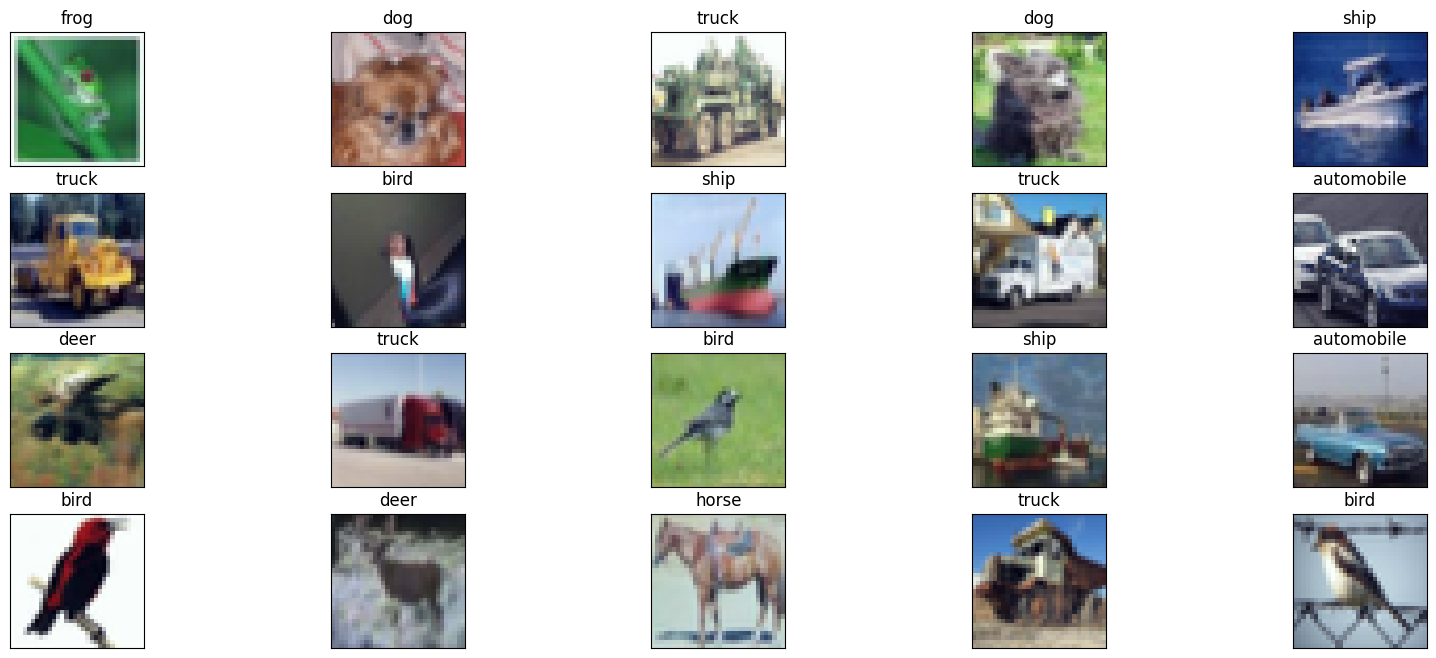

In [3]:
show_random_samples(test_loader, classes)

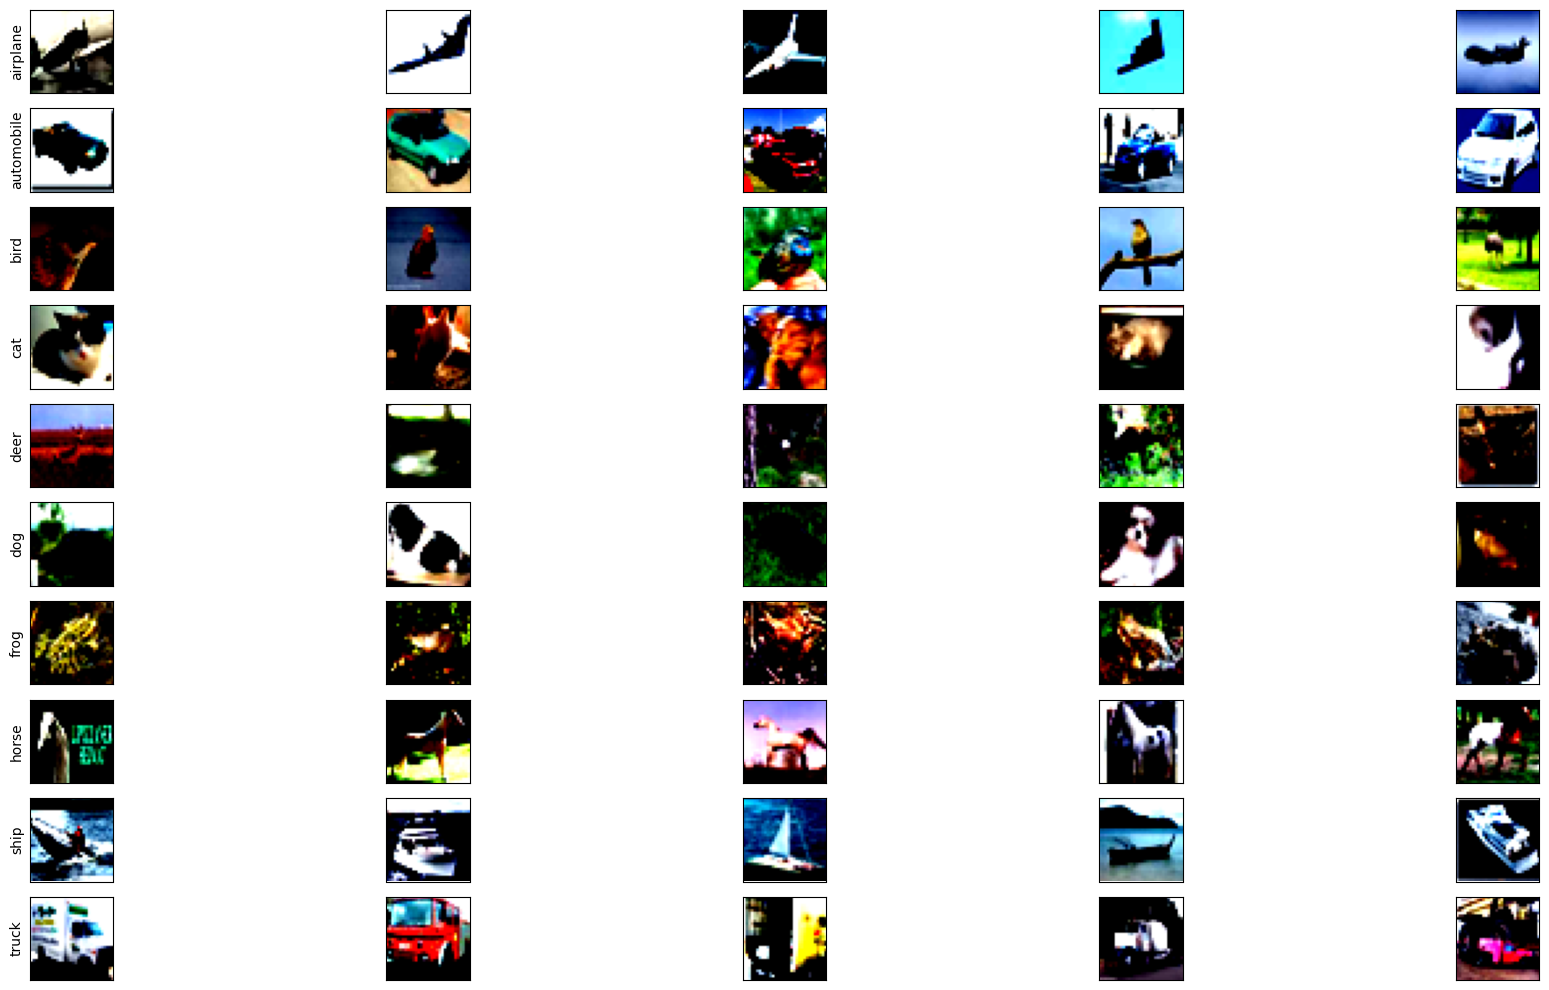

In [4]:
show_class_samples(test_loader, classes)

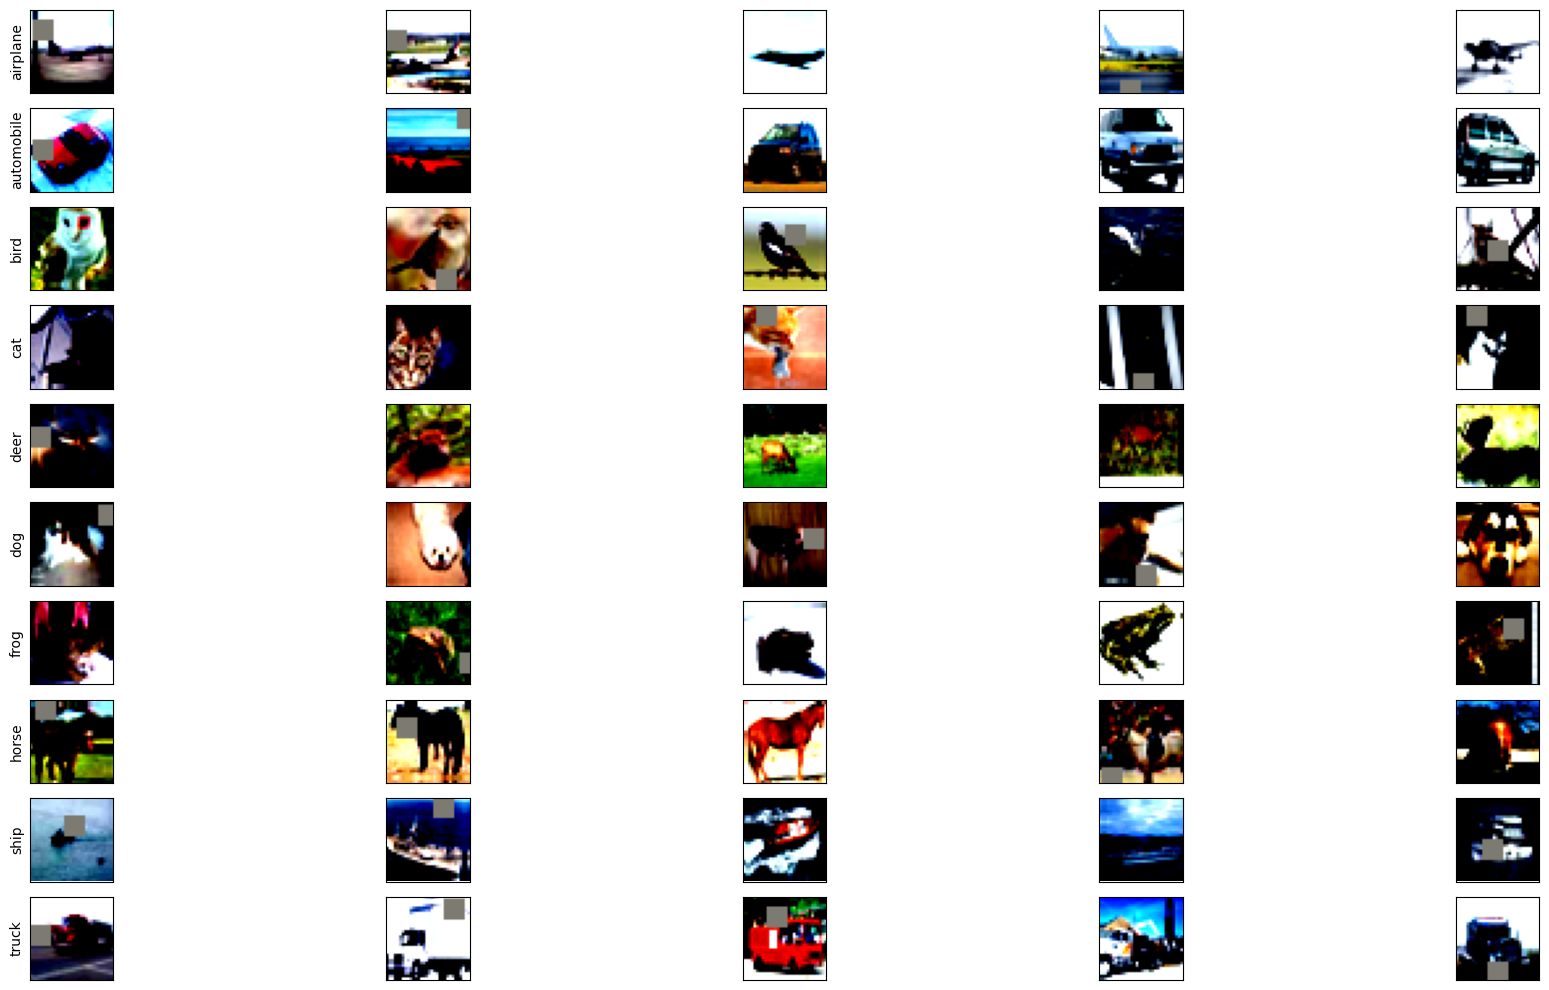

In [5]:
# After applying augmentations
show_class_samples(train_loader, classes)

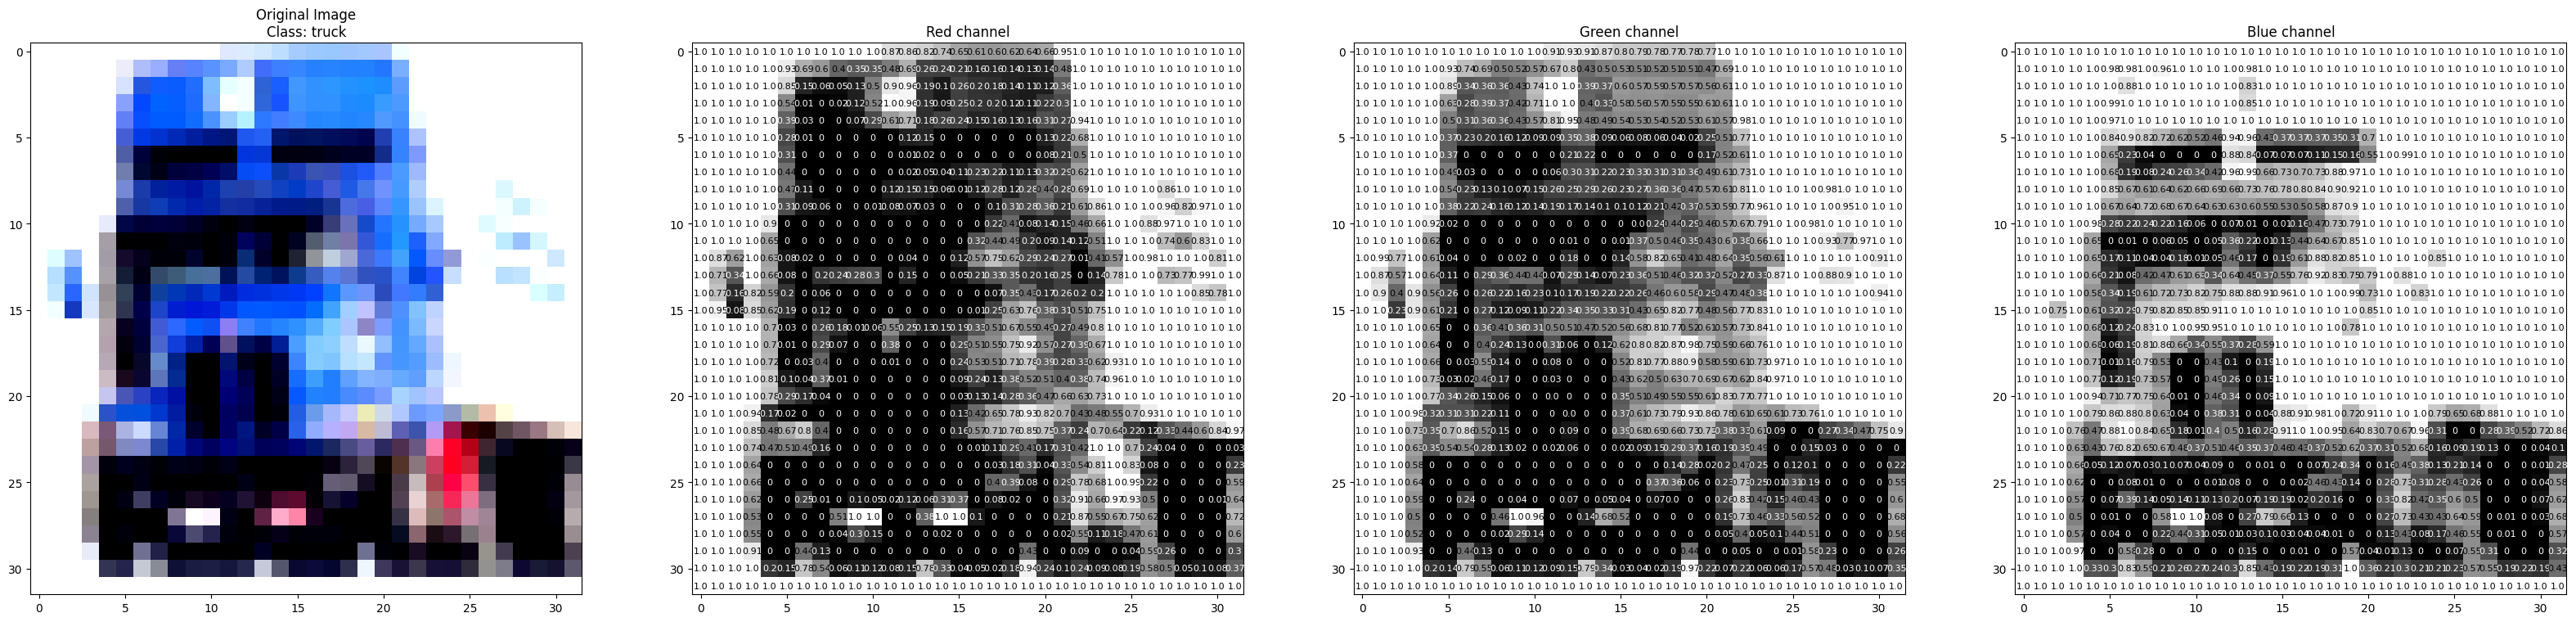

In [6]:
show_image_rgb(test_loader, classes)

## Initializing model and model summary
(from custom_resnet_model)

In [7]:
# using batch norm
model = custom_ResNet().to(device)
model.model_summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

## Finding Max Learning Rate usng LRfinder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.48E-04


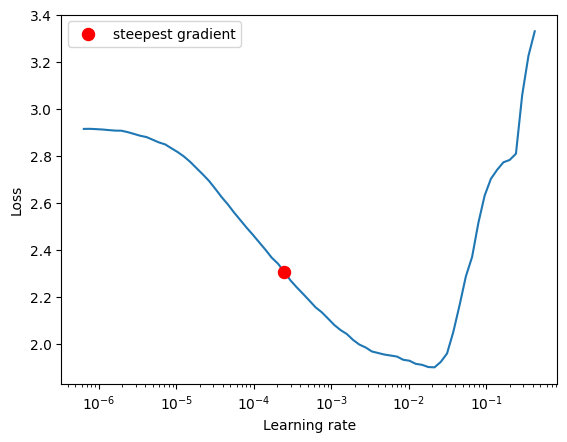

In [8]:
# Define optimizer and criterion for loss
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-1)
criterion = nn.CrossEntropyLoss()

# Specify end LR, number of iterations and step mode
end_lr = 10
num_iter = 100
step_mode = "exp"

# Passing to find_max_lr in utils
max_LR = find_max_lr(optimizer, criterion, model, train_loader, end_lr, num_iter, step_mode)


# Model Training and Prediction


In [9]:

# Define the number of epochs and the max epoch for max learning rate
total_epochs = 24
max_lr_epoch = 5

# Define the learning rate scheduler with max LR from LRFinder
# Max LR is achieved by 5th epoch
# Annealing is set to false by three_phase=False
lr_scheduler = OneCycleLR( optimizer, max_lr=max_LR, steps_per_epoch=len(train_loader), epochs=total_epochs,
                          pct_start=max_lr_epoch/total_epochs, div_factor=100, three_phase=False, final_div_factor=100,
                           anneal_strategy='linear')

# Passing each batch to train and test in train_test module
EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, lr_scheduler, criterion, train_loader, optimizer, epoch)
    misclassified_images, misclassified_labels, misclassified_predictions = test(model, device, criterion, test_loader)
    print("\n")


EPOCH: 1


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]


Train Average Loss: 1.7908
Train Accuracy: 36.93%
Maximum Learning Rate:  5.1623487001864064e-05


Test Average loss: 1.2957
Test Accuracy: 53.21%


EPOCH: 2


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Train Average Loss: 1.1900
Train Accuracy: 57.89%
Maximum Learning Rate:  0.00010076989764773643


Test Average loss: 1.0542
Test Accuracy: 62.44%


EPOCH: 3


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Train Average Loss: 0.9822
Train Accuracy: 65.41%
Maximum Learning Rate:  0.00014991630829360876


Test Average loss: 0.9402
Test Accuracy: 67.84%


EPOCH: 4


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]


Train Average Loss: 0.8490
Train Accuracy: 70.20%
Maximum Learning Rate:  0.00019906271893948112


Test Average loss: 0.7477
Test Accuracy: 73.90%


EPOCH: 5


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Train Average Loss: 0.7527
Train Accuracy: 73.83%
Maximum Learning Rate:  0.0002475746158006558


Test Average loss: 0.7346
Test Accuracy: 74.54%


EPOCH: 6


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Train Average Loss: 0.6769
Train Accuracy: 76.28%
Maximum Learning Rate:  0.0002345386755461499


Test Average loss: 0.6632
Test Accuracy: 76.84%


EPOCH: 7


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Train Average Loss: 0.6132
Train Accuracy: 78.81%
Maximum Learning Rate:  0.00022150273529164405
Test Average loss: 0.5988
Test Accuracy: 79.32%


EPOCH: 8


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Train Average Loss: 0.5663
Train Accuracy: 80.59%
Maximum Learning Rate:  0.0002084667950371382


Test Average loss: 0.5755
Test Accuracy: 80.02%


EPOCH: 9


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Train Average Loss: 0.5263
Train Accuracy: 81.80%
Maximum Learning Rate:  0.00019543085478263233


Test Average loss: 0.5166
Test Accuracy: 82.74%


EPOCH: 10


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Train Average Loss: 0.4943
Train Accuracy: 83.06%
Maximum Learning Rate:  0.0001823949145281265


Test Average loss: 0.4850
Test Accuracy: 83.24%


EPOCH: 11


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Train Average Loss: 0.4716
Train Accuracy: 83.79%
Maximum Learning Rate:  0.00016935897427362064


Test Average loss: 0.4739
Test Accuracy: 83.57%


EPOCH: 12


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Train Average Loss: 0.4477
Train Accuracy: 84.67%
Maximum Learning Rate:  0.00015632303401911477


Test Average loss: 0.4687
Test Accuracy: 83.93%


EPOCH: 13


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Train Average Loss: 0.4216
Train Accuracy: 85.50%
Maximum Learning Rate:  0.00014328709376460892


Test Average loss: 0.4591
Test Accuracy: 84.02%


EPOCH: 14


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Train Average Loss: 0.3978
Train Accuracy: 86.39%
Maximum Learning Rate:  0.00013025115351010308


Test Average loss: 0.4378
Test Accuracy: 84.63%


EPOCH: 15


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Train Average Loss: 0.3781
Train Accuracy: 87.02%
Maximum Learning Rate:  0.00011721521325559723


Test Average loss: 0.4007
Test Accuracy: 86.14%


EPOCH: 16


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Train Average Loss: 0.3538
Train Accuracy: 88.02%
Maximum Learning Rate:  0.00010417927300109138


Test Average loss: 0.3794
Test Accuracy: 87.07%


EPOCH: 17


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Train Average Loss: 0.3278
Train Accuracy: 88.89%
Maximum Learning Rate:  9.114333274658551e-05


Test Average loss: 0.3817
Test Accuracy: 87.33%


EPOCH: 18


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


Train Average Loss: 0.3056
Train Accuracy: 89.73%
Maximum Learning Rate:  7.810739249207964e-05


Test Average loss: 0.3690
Test Accuracy: 87.38%


EPOCH: 19


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Train Average Loss: 0.2796
Train Accuracy: 90.60%
Maximum Learning Rate:  6.507145223757382e-05


Test Average loss: 0.3163
Test Accuracy: 89.31%


EPOCH: 20


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Train Average Loss: 0.2473
Train Accuracy: 91.82%
Maximum Learning Rate:  5.2035511983067946e-05


Test Average loss: 0.3112
Test Accuracy: 89.12%


EPOCH: 21


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Train Average Loss: 0.2125
Train Accuracy: 92.91%
Maximum Learning Rate:  3.89995717285621e-05


Test Average loss: 0.2745
Test Accuracy: 90.98%


EPOCH: 22


Batch_id=97: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Train Average Loss: 0.1768
Train Accuracy: 94.22%
Maximum Learning Rate:  2.5963631474056227e-05
Test Average loss: 0.2578
Test Accuracy: 91.47%


EPOCH: 23


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Train Average Loss: 0.1339
Train Accuracy: 95.75%
Maximum Learning Rate:  1.2927691219550408e-05


Test Average loss: 0.2337
Test Accuracy: 92.31%


EPOCH: 24


Batch_id=97: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Train Average Loss: 0.0974
Train Accuracy: 97.09%
Maximum Learning Rate:  -1.0824903495543778e-07


Test Average loss: 0.2182
Test Accuracy: 92.86%




## Train and Test Loss/Accuracy
(from visualize module)

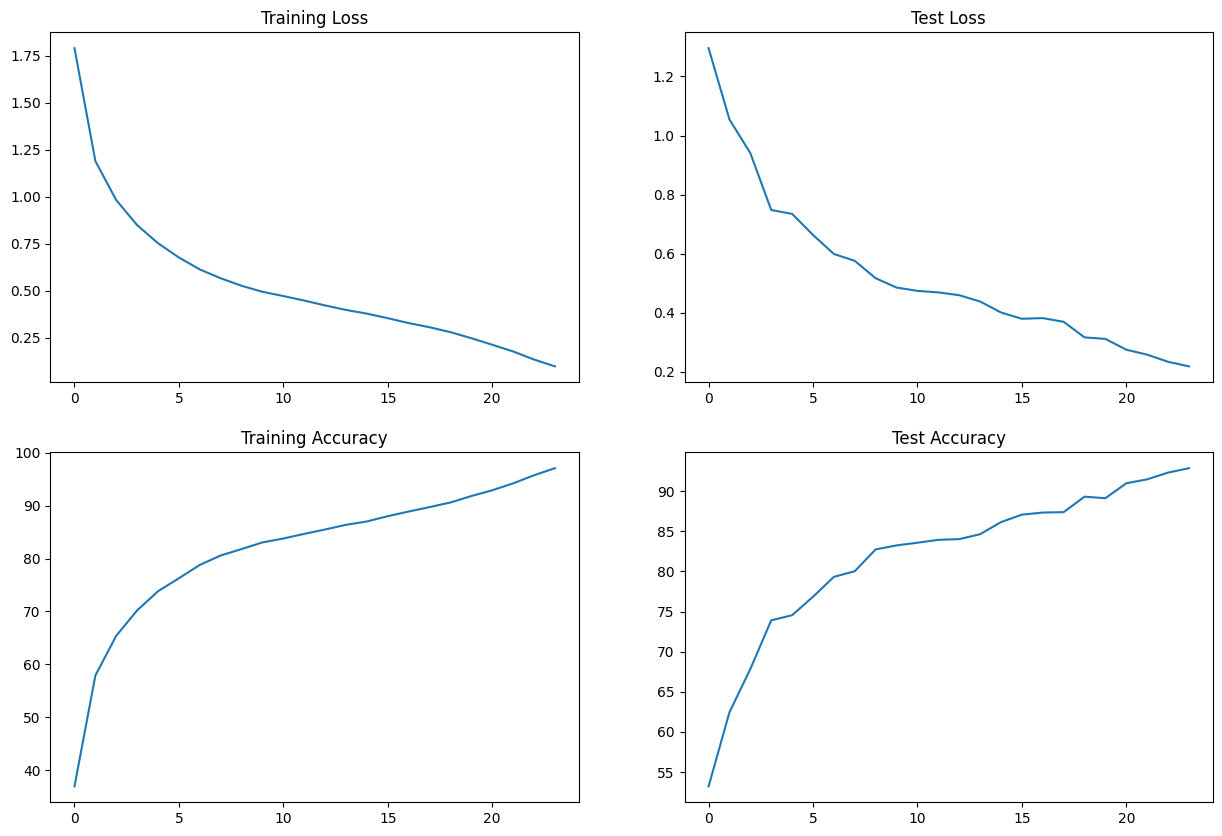

In [10]:
show_accuracy_loss(train_test.train_losses, train_test.train_accuracies, train_test.test_losses, train_test.test_accuracies)

## Misclassified Images
(from visualize module)

Misclassified Images:


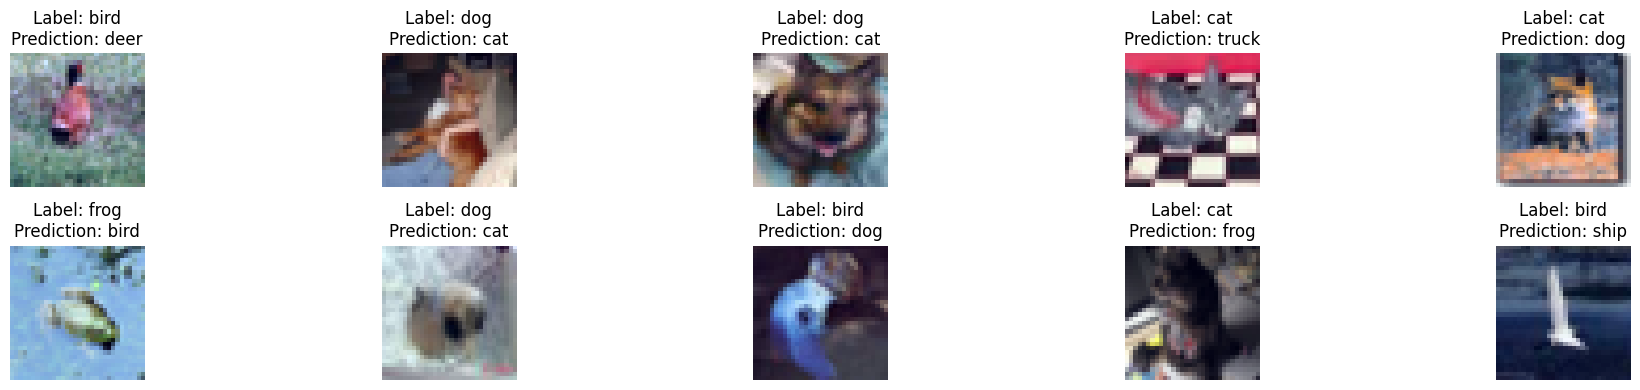

In [11]:
show_misclassified_img(misclassified_images, misclassified_labels, misclassified_predictions, classes)